In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import collections
import string
import emoji
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_extraction.text import CountVectorizer

In [51]:
corpus1 = pd.read_csv("C:/Users/Ung Lik Teng/Desktop/CodenData/Machine Learning/Machine Learning dataset/twitter_corpus/full-corpus.csv")

Here I have collected three datasets for the purpose of this project;
1. [Sanders corpus](https://github.com/zfz/twitter_corpus)
2. [2016 First GOP Debate](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment/data)
3. [Tweets Dataset](https://www.kaggle.com/c/twitter-sentiment-analysis2/data)

In [3]:
corpus1.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


In [4]:
corpus1.shape

(5113, 5)

In [5]:
corpus2 = pd.read_csv("C:/Users/Ung Lik Teng/Desktop/CodenData/Machine Learning/Machine Learning dataset/sentiment.csv", index_col = 0)

In [6]:
corpus2.head()

,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
id,,,,,,,,,,,,,,,,,,,,
1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [7]:
corpus2.shape

(13871, 20)

In [8]:
corpus3 = pd.read_csv("C:/Users/Ung Lik Teng/Desktop/CodenData/Machine Learning/Machine Learning dataset/twitter-sentiment-analysis2/train.csv", index_col = 0, encoding='latin-1')

In [9]:
corpus3.head()

,Sentiment,SentimentText
ItemID,,
1,0,is so sad for my APL frie...
2,0,I missed the New Moon trail...
3,1,omg its already 7:30 :O
4,0,.. Omgaga. Im sooo im gunna CRy. I'...
5,0,i think mi bf is cheating on me!!! ...


In [10]:
corpus3.shape

(99989, 2)

## Text Cleaning
We need to perform text cleaning on the original dataset first before extracting features. I am creating a class TextCleaner() which will do the following:

- remove mention (@)
- remove hashtag sign (#) but retain the words because it might contain important information
- apply slang dictionary
- apply emoji dictionary
- remove all punctuations
- remove the url links (think about it again)
- change to lowercase
- remove stopwords 
- remove digits 
- apply PorterStemmer to keep the stem word

In [11]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def rmv_mention(self, text):
        return re.sub(r'@\w+', '', text)
    
    def rmv_hashtag(self, text):
        return re.sub(r'#', '', text)
    
    def rmv_punctuation(self, text):
        #This create a translation table that maps every punctuation to a space
        punctuation_table = str.maketrans(string.punctuation, len(string.punctuation)*' ' )
        return text.translate(punctuation_table)
    
    def treat_emoji(self,text):
        demoji_text = emoji.demojize(text)
        #The emoji is transformed into the format of :emoji_name:
        #We now ant to remove the underscore from the emoji
        return demoji_text.replace('_','')
        
    
    def rmv_urls(self, text):
        return re.sub(r'http.?//[^\s]+[\s]?', '', text)
    
    def rmv_digits(self, text):
        return re.sub(r'\d+', '', text)
    
    def to_lower(self, text):
        return text.lower()
    
    def rmv_stopwords(self, text):
        stopwords_list = stopwords.words('english')
        retained_words = ['no', 'not', 'nor', "n't"]
        cleaned_words = [word for word in word_tokenize(text) if (word not in stopwords_list or word in retained_words) and len(word)> 1]
        return " ".join(cleaned_words)
    
    def stemming(self, text):
        PorterStem = PorterStemmer()
        word_stem = [PorterStem.stem(word) for word in word_tokenize(text)]
        return " ".join(word_stem)
    
        
    def fit(self, X, y =None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_text = X.apply(self.rmv_mention).apply(self.rmv_hashtag).apply(self.rmv_punctuation).apply(self.treat_emoji).apply(self.rmv_urls).apply(self.rmv_digits).apply(self.to_lower).apply(self.rmv_stopwords).apply(self.stemming)
        return clean_text

## Text Variable 
Create a class CountFeature to compute basic statistics on the text data.

- count_words : number of words in the tweet
- count_mentions : referrals to other Twitter accounts, which are preceded by a @
- count_hashtags : number of tag words, preceded by a #
- count_capital_words : number of uppercase words, could be used to "shout" and express (negative) emotions
- count_excl_quest_marks : number of question or exclamation marks
- count_urls : number of links in the tweet, preceded by http(s)


In [12]:
class CountFeature(BaseEstimator, TransformerMixin):
    
    def count_regex(self,pattern,tweet):
        return len(re.findall(pattern,tweet))
    
    def fit(self,X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                          })
            
        return df


In [13]:
textcleaner = TextCleaner()
df_clean = textcleaner.fit_transform(corpus3.SentimentText)

In [14]:
empty_clean = df_clean == ''
print('{} records have no words left after text cleaning'.format(df_clean[empty_clean].count()))
df_clean.loc[empty_clean] = '[no_text]'

821 records have no words left after text cleaning


C:\Users\Ung Lik Teng\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


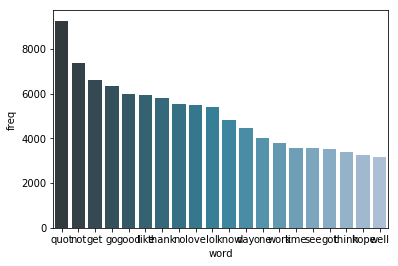

In [15]:
countVec = CountVectorizer()
df_cv = countVec.fit_transform(df_clean)
word_freq = dict(zip(countVec.get_feature_names(), np.asarray(df_cv.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word','freq'])

fig, ax = plt.subplots()
sns.barplot(x="word", y="freq", data=word_counter_df, palette= "PuBuGn_d",ax=ax)

In [16]:
cf = CountFeature()
df_new = cf.fit_transform(corpus3.SentimentText)
df_new['Sentiment'] = corpus3.Sentiment

In [18]:
df = cf.fit_transform(df_clean)
df.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls
ItemID,,,,,,
1,3,0,0,0,0,0
2,4,0,0,0,0,0
3,2,0,0,0,0,0
4,13,0,0,0,0,0
5,4,0,0,0,0,0


In [19]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99989 entries, 1 to 100000
Data columns (total 7 columns):
count_words               99989 non-null int64
count_mentions            99989 non-null int64
count_hashtags            99989 non-null int64
count_capital_words       99989 non-null int64
count_excl_quest_marks    99989 non-null int64
count_urls                99989 non-null int64
Sentiment                 99989 non-null int64
dtypes: int64(7)
memory usage: 6.1 MB


In [21]:
df_model = df_new
df_model['clean_text'] = df_clean
df_model['clean_count_words'] = df.count_words
df_model.columns.tolist()


['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'Sentiment',
 'clean_text',
 'clean_count_words']

In [23]:
df_model.to_csv("cleaned.csv", index = False)

# Sander Corpus (Corpus 1)

In [53]:
corpus1.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


In [54]:
df = corpus1[['Sentiment', 'TweetText']]

In [55]:
df.Sentiment[df.Sentiment == 'positive'] = 1 
df.Sentiment[df.Sentiment == 'negative'] = -1

C:\Users\Ung Lik Teng\Anaconda3\lib\site-packages\pandas\core\generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Ung Lik Teng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [56]:
df.head()

,Sentiment,TweetText
0,1,Now all @Apple has to do is get swype on the i...
1,1,@Apple will be adding more carrier support to ...
2,1,Hilarious @youtube video - guy does a duet wit...
3,1,@RIM you made it too easy for me to switch to ...
4,1,I just realized that the reason I got into twi...


In [57]:
df_clean = textcleaner.fit_transform(df.TweetText)
df_clean

0                             get swype iphon crack iphon
1                        ad carrier support iphon announc
2       hilari video guy duet siri pretti much sum lov...
3                           made easi switch iphon see ya
4                      realiz reason got twitter io thank
5                  current user littl bit disappoint move
6       strangest thing siri said far sooo glad gave s...
7        great close person event tonight regent st store
8                  compani experi best custom servic asid
9                                 appli job hope call lol
10      rt lmao think onto someth magic die haha siri ...
11      lmao think onto someth magic die haha siri sug...
12      rt regist develop hope actual help greatli app...
13      wow great deal refurb ipad first gen model rt ...
14        regist develop hope actual help greatli appreci
15      你好 current learn mandarin upcom trip hong kong...
16      come dark side mobilephon hey send free iphon ...
17      hey se

In [58]:
empty_clean = df_clean == ''
print('{} records have no words left after text cleaning'.format(df_clean[empty_clean].count()))
df_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


C:\Users\Ung Lik Teng\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


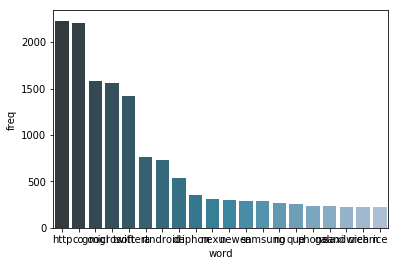

In [59]:
countVec = CountVectorizer()
df_cv = countVec.fit_transform(df_clean)
word_freq = dict(zip(countVec.get_feature_names(), np.asarray(df_cv.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word','freq'])

fig, ax = plt.subplots()
sns.barplot(x="word", y="freq", data=word_counter_df, palette= "PuBuGn_d",ax=ax)

In [60]:
word_counter.most_common(20)

[('http', 2231),
 ('co', 2210),
 ('googl', 1580),
 ('microsoft', 1563),
 ('twitter', 1415),
 ('rt', 765),
 ('android', 735),
 ('de', 534),
 ('iphon', 348),
 ('nexu', 310),
 ('new', 295),
 ('en', 292),
 ('samsung', 284),
 ('no', 270),
 ('que', 260),
 ('phone', 238),
 ('galaxi', 234),
 ('sandwich', 229),
 ('cream', 225),
 ('ice', 225)]

In [61]:
df_new = cf.fit_transform(df.TweetText)
df_new['Sentiment'] = df.Sentiment

In [62]:
df = cf.fit_transform(df_clean)
df.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls
0,5,0,0,0,0,0
1,5,0,0,0,0,0
2,13,0,0,0,0,0
3,6,0,0,0,0,0
4,6,0,0,0,0,0


In [63]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 7 columns):
count_words               5113 non-null int64
count_mentions            5113 non-null int64
count_hashtags            5113 non-null int64
count_capital_words       5113 non-null int64
count_excl_quest_marks    5113 non-null int64
count_urls                5113 non-null int64
Sentiment                 5113 non-null object
dtypes: int64(6), object(1)
memory usage: 279.7+ KB


In [64]:
df_model = df_new
df_model = df_model[(df_model.Sentiment != 'irrelevant')]
df_model.Sentiment[(df_model.Sentiment == 'neutral')] = 0

C:\Users\Ung Lik Teng\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ung Lik Teng\Anaconda3\lib\site-packages\pandas\core\generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Ung Lik Teng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [65]:
df_model['clean_text'] = df_clean
df_model['clean_count_words'] = df.count_words
df_model.columns.tolist()

C:\Users\Ung Lik Teng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ung Lik Teng\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'Sentiment',
 'clean_text',
 'clean_count_words']

In [66]:
df_model.to_csv("sanders_cleaned.csv", index = False)

In [67]:
df_model

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,Sentiment,clean_text,clean_count_words
0,20,1,0,0,0,0,1,get swype iphon crack iphon,5
1,13,1,0,0,0,0,1,ad carrier support iphon announc,5
2,22,2,0,0,1,1,1,hilari video guy duet siri pretti much sum lov...,13
3,15,2,0,1,1,0,1,made easi switch iphon see ya,6
4,14,1,0,0,0,0,1,realiz reason got twitter io thank,6
5,19,4,0,0,1,0,1,current user littl bit disappoint move,6
6,27,2,0,1,1,1,1,strangest thing siri said far sooo glad gave s...,15
7,11,1,0,0,1,0,1,great close person event tonight regent st store,8
8,15,2,0,0,1,0,1,compani experi best custom servic asid,6
9,12,1,0,0,0,0,1,appli job hope call lol,5
